# Preprocessing of Fluctuations data

**Author:** M.G. Baltussen

**Estimated running time:** 1 minute

**Generated output:**
```
data/fluctuations.csv
plots_extended/fluctuations_traces.{svg,png}
```

In [1]:
""" System imports """

import pathlib
import toml

""" Essential imports"""
import numpy as np
import pandas as pd

""" ML/RC imports """
from sklearn.feature_selection import mutual_info_regression as mi_reg
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn import metrics

from pyrcn.echo_state_network import ESNClassifier


""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns

sns.set_theme(
    style="ticks",
    context="paper",
    font_scale=0.7,
    rc={
        "axes.linewidth": 0.5,
        "axes.facecolor": "#eceff4",
        "axes.edgecolor": "#2e3440",
        "axes.labelcolor": "#2e3440",
        "text.color": "#2e3440",
        "xtick.color": "#2e3440",
        "ytick.color": "#2e3440",
        "font.family": "Arial",
        "svg.fonttype": "none",
    },
)
import colorcet as cc

nord_palette = [
    "#bf616a",
    "#d08770",
    "#ebcb8b",
    "#a3be8c",
    "#b48ead",
    "#8fbcbb",
    "#88c0d0",
    "#81a1c1",
    "#5e81ac",
    "#2e3440",
    "#3b4252",
    "#434c5e",
    "#4c566a",
    "#d8dee9",
    "#e5e9f0",
    "#eceff4",
]

sns.set_palette(nord_palette)


def save_plot(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots/{name}.svg", **kwargs)
    plt.savefig(f"../plots/{name}.png", dpi=600, **kwargs)


def save_si(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots_extended/{name}.svg", **kwargs)
    plt.savefig(f"../plots_extended/{name}.png", dpi=600, **kwargs)

In [2]:
""" Load input flows and remove initial steady-state """

flowrate = 435 / (2 * 60)  # ul/s

inputs = pd.read_excel(
    "../data/fluctuations_input.xlsx",
    usecols=[0, 1, 2, 3, 4],
    names=["time", "DHA", "NaOH", "CaCl2", "formaldehyde"],
)
inputs = inputs.assign(time=inputs.time.shift().cumsum() / flowrate)

In [3]:
inputs.query('time > 10000').head(10)

,time,DHA,NaOH,CaCl2,formaldehyde
5408,10020.0,20.383358,36.25,36.25,36.25
5409,10080.0,64.161866,36.25,36.25,36.25
5410,10140.0,46.647566,36.25,36.25,36.25
5411,10200.0,26.721440,36.25,36.25,36.25
5412,10260.0,38.312247,36.25,36.25,36.25
5413,10320.0,49.038881,36.25,36.25,36.25
5414,10380.0,29.334337,36.25,36.25,36.25
5415,10440.0,57.307512,36.25,36.25,36.25
5416,10500.0,33.132670,36.25,36.25,36.25
5417,10560.0,31.224439,36.25,36.25,36.25


In [4]:
""" Load ion signals, align with input and bin into 10s timeblocks"""

OFFSET_DATA = 1400

files = pathlib.Path("../data/fluctuations/").glob("*.dat")
df = pd.concat(
    (pd.read_csv(f, sep="\t").assign(species=f.stem) for f in files), ignore_index=True
)
df = df.assign(retention_time=df.retention_time.round(1)).rename(
    columns={"retention_time": "time"}
)
df = df.pivot(index=["time"], columns="species", values="intensity")
df = df.reset_index()

bins = np.arange(5, df.time.max() + 5, 10, dtype=int)
df = df.assign(time=pd.cut(df.time, bins=bins, labels=bins[1:] - 5, right=True))
df = df.groupby("time").mean().reset_index()
df = df.assign(time=df.time.astype(int) - OFFSET_DATA).set_index("time")

df_inputs = (
    inputs.assign(time=inputs.time - 10_000)
    .query("time > 0")
    .set_index("time", drop=True)
)
df_inputs.index = df_inputs.index.astype("int64")
df_data = df.assign(time=df.index - 9870).query("time > 0").set_index("time", drop=True)

df_inputs = df_inputs.reindex(
    range(df_inputs.index.min(), df_inputs.index.max(), 10)
).ffill()

df_data = df_data.loc[df_data.index.intersection(df_inputs.index)].fillna(0)
df_inputs = df_inputs.loc[df_data.index]

df_all = pd.concat([df_inputs, df_data], axis=1)
df_all.to_csv("../data/fluctuations.csv", index=True)

/tmp/ipykernel_5766/82329537.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby("time").mean().reset_index()


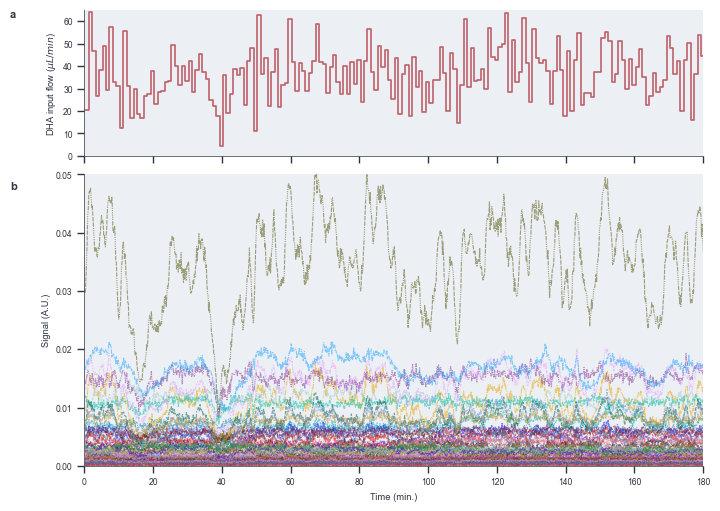

In [5]:
""" Plot flow inputs together with observed ion signals"""

fig, axes = plt.subplots(
    2,
    1,
    constrained_layout=True,
    figsize=(7.087, 5.0),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 2]},
)
sns.lineplot(ax=axes[0], data=df_inputs[::6], x="time", y="DHA", drawstyle="steps-post")


sns.lineplot(
    ax=axes[1],
    data=df_data,
    legend=None,
    lw=0.8,
    palette=cc.glasbey_dark[: df.shape[1]],
    alpha=0.5,
)

axes[0].set_ylabel(r"DHA input flow ($\mu L/min$)")
axes[1].set_ylabel("Signal (A.U.)")
axes[1].set_xlabel("Time (min.)")
axes[0].set_ylim(0, 65)
axes[1].set_ylim(0, 0.05)

axes[0].text(-0.12, 0.95, "a", transform=axes[0].transAxes, weight="bold", size=8)
axes[1].text(-0.12, 0.95, "b", transform=axes[1].transAxes, weight="bold", size=8)

axes[1].set_xlim(0, 180 * 60)
axes[1].set_xticks([i * 1200 for i in range(10)], [i * 20 for i in range(10)])

sns.despine()
save_si("fluctuations_traces")
plt.show()